In [769]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split,DataLoader
import yfinance as yf
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import matplotlib.pyplot as plt

In [770]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS
else:
    device = torch.device("cpu")  # Fallback to CPU

In [771]:
df = pd.read_csv("sentimentadded.csv")

individual_reports = []

for i,group in df.groupby("time"):
    for j,ticker in group.groupby("ticker"):
        individual_reports.append(ticker)

stock_data = {}
        
for ticker in df["ticker"].unique():
    t = yf.Ticker(ticker)
    stock_data[ticker] = t.history('max')

In [772]:
for key in stock_data:
    #stock_data[key] = (stock_data[key]["Close"]-stock_data[key]["Close"].values[0])/stock_data[key]["Close"].std()
    # Ratio of returns 
    stock_data[key] = stock_data[key]["Close"]/stock_data[key]["Close"].values[0] - 1

In [773]:
print(stock_data["NVDA"])

Date
1999-01-22 00:00:00-05:00       0.000000
1999-01-25 00:00:00-05:00       0.104764
1999-01-26 00:00:00-05:00       0.019041
1999-01-27 00:00:00-05:00       0.015872
1999-01-28 00:00:00-05:00       0.012678
                                ...     
2024-12-04 00:00:00-05:00    3857.284403
2024-12-05 00:00:00-05:00    3855.423257
2024-12-06 00:00:00-05:00    3785.770629
2024-12-09 00:00:00-05:00    3689.266868
2024-12-10 00:00:00-05:00    3589.839145
Name: Close, Length: 6514, dtype: float64


In [774]:
numin = set()
for report in individual_reports:
    for unqt in report["tag"].unique():
        numin.add(unqt)

indmap = {}

for i,j in enumerate(numin):
    indmap[j] = i

In [775]:
class StockDataset(Dataset):
    def __init__(self,reports,historical_data):
        self.reports = reports
        self.historical_data = historical_data
        self.data_len = 0
        self.data_blocks = []
        self.sent_blocks = []
        self.labels = []

        self.construct_dataset()

    def get_year_data(self,year,ticker):
        """Get a specific year of stock data to build block"""
        mask = stock_data[ticker].index.year == year
        filtered_data = stock_data[ticker][mask]
        return filtered_data.values
    
    def split_to_windows(self,stock_data,window_size=60):
        windows = np.array([stock_data[i:i + window_size] for i in range(len(stock_data) - window_size)])
        labels = np.array([stock_data[i + window_size] for i in range(len(stock_data) - window_size)])
        return windows,labels

    def construct_dataset(self):
        for report in self.reports:
            # map sentiments to specific spot in area to keep consistent
            sentiment_values = np.zeros(len(indmap))
            for i,row in report.iterrows():
                tag = row["tag"]
                sentiment_values[indmap[tag]] = (row["sentiment"] * 2) - 1 # make a distance -1 and 1 
            
            # get corresponding year
            stock_values = self.get_year_data(report["year"].values[0],report["ticker"].values[0])
            #split into windows of 60
            windows,labels = self.split_to_windows(stock_values)

            for i,window in enumerate(windows):
                # construct one X-y pair
                lab = report["percentage_change"].unique()[0]
                db = torch.from_numpy(window).to(torch.float32)
                self.data_blocks.append(db)
                sb = torch.from_numpy(sentiment_values).to(torch.float32)
                self.sent_blocks.append(sb)
                labt = torch.tensor([labels[i]]).to(torch.float32)
                self.labels.append(labt)
        
        #self.data_blocks = pad_sequence(self.data_blocks,batch_first=True,padding_value=0)
    
    def create_one_stock(self,stock):
        osblocks = [] # one stock blocks sentiments and labels
        ossents = []
        oslabs = []
        for report in self.reports:
            if(report["ticker"].values[0] != stock):
                continue
            # map sentiments to specific spot in area to keep consistent
            sentiment_values = np.zeros(len(indmap))
            for i,row in report.iterrows():
                tag = row["tag"]
                sentiment_values[indmap[tag]] = (row["sentiment"] * 2) - 1 # make a distance -1 and 1 
            
            # get corresponding year
            stock_values = self.get_year_data(report["year"].values[0],report["ticker"].values[0])
            #split into windows of 60
            windows,labels = self.split_to_windows(stock_values)

            for i,window in enumerate(windows):
                # construct one X-y pair
                db = torch.from_numpy(window).to(torch.float32)
                osblocks.append(db)
                sb = torch.from_numpy(sentiment_values).to(torch.float32)
                ossents.append(sb)
                labt = torch.tensor([labels[i]]).to(torch.float32)
                oslabs.append(labt)
        
        #osblocks = pad_sequence(self.data_blocks,batch_first=True,padding_value=0)

        xlist = []

        for i, block in enumerate(osblocks):
            xlist.append((block,ossents[i],oslabs[i]))

        return xlist

    def __len__(self):
        return len(self.data_blocks)

    def __getitem__(self, idx):
        return self.data_blocks[idx],self.sent_blocks[idx],self.labels[idx]
    
sd = StockDataset(individual_reports,stock_data)

In [776]:
train_dataset, test_dataset = random_split(sd, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [777]:
class PricePredictor(nn.Module):
    def __init__(self):
        super().__init__()

        # LSTM Layer hidden state 
        self.stock_layer = nn.LSTM(60,1024,5) 

        self.sent_layer = nn.Sequential(
            #Stock layer + sent_layer for final pred
            nn.Linear(1024+6,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,1),
            nn.ReLU()
        )

    def forward(self,stock,sent):
        lstm_out = self.stock_layer(stock)[0] # Get return from lstm
        return self.sent_layer(torch.hstack((lstm_out.squeeze(1),sent)))

In [778]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (stockx,sentx, y) in enumerate(dataloader):
        # Compute prediction and loss
        x1 = stockx.unsqueeze(1).to(device)
        x2 = sentx.to(device)
        pred = model.forward(x1,x2)
        #pred = model(stockx,sentx)
        loss = loss_fn(pred, y.to(device))


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * 64 + len(stockx)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for stockx,sentx, y in dataloader:
            pred = model.forward(stockx.unsqueeze(1).to(device),sentx.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
    test_loss /= num_batches
    print(f"Accum loss {test_loss}")

In [780]:
model = PricePredictor()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    #test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 229886.500000  [   64/ 8277]
loss: 320141.718750  [ 6464/ 8277]
Epoch 2
-------------------------------
loss: 188424.250000  [   64/ 8277]
loss: 362261.187500  [ 6464/ 8277]
Epoch 3
-------------------------------
loss: 176808.500000  [   64/ 8277]
loss: 119660.460938  [ 6464/ 8277]
Epoch 4
-------------------------------
loss: 285176.937500  [   64/ 8277]
loss: 256292.062500  [ 6464/ 8277]
Epoch 5
-------------------------------
loss: 253177.031250  [   64/ 8277]
loss: 196333.062500  [ 6464/ 8277]
Done!


In [ ]:
test_loop(test_dataloader,model,loss_fn)

Accum loss 162408.87121212122


In [ ]:
os = sd.create_one_stock("NVDA")
print(len(os))
preds = []

for stockx,sentx,_ in os:
    pred = model.forward(stockx.unsqueeze(0).to(device),sentx.to(device).unsqueeze(0))
    preds.append(pred.cpu().detach().numpy())

1916


In [ ]:
preds = np.array(preds).reshape((1916))

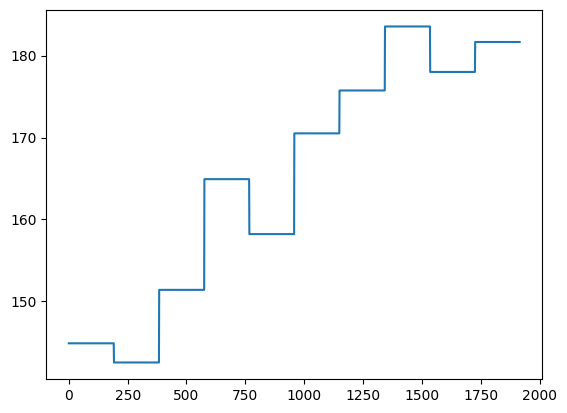

In [781]:
#plt.plot(list(range(len(stock_data["NVDA"]))),stock_data["NVDA"])
plt.plot(list(range(len(preds))),preds)